In [1]:
import pymc3 as pm
import matplotlib

In [2]:
# rcParams
matplotlib.rc("font", family="Malgun Gothic")

`with`문을 통해서 `model` 내 변수 선언이 편해짐.
- 여기 안에서 (context라고 표현함) 선언된 변수는 `model`에 대한 속성으로 assign됨
- 밖에서 선언하면 error가 발생함

In [28]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

In [29]:
model.__dict__

{'_parent': None,
 '_theano_config': {'compute_test_value': 'raise'},
 '_config_context': <theano.configparser._ChangeFlagsDecorator at 0x7fd410613a60>,
 'name': '',
 'coords': {},
 'RV_dims': {},
 'check_bounds': True,
 'named_vars': {'poisson_param_log__': poisson_param_log__ ~ TransformedDistribution,
  'poisson_param': poisson_param ~ Exponential,
  'data_generator': data_generator ~ Poisson},
 'free_RVs': [poisson_param_log__ ~ TransformedDistribution,
  data_generator ~ Poisson],
 'observed_RVs': [],
 'deterministics': [poisson_param ~ Exponential],
 'potentials': [],
 'missing_values': [],
 'poisson_param_log__': poisson_param_log__ ~ TransformedDistribution,
 'poisson_param': poisson_param ~ Exponential,
 'data_generator': data_generator ~ Poisson}

In [30]:
parameter.tag.test_value

array(0.69314718)

In [31]:
param2 = pm.Poisson("test_2", 3)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

다시 `with model`로 부를 수 있음

In [32]:
with model:
    data_plus_one = data_generator + 1

In [34]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2.0)
    data_generator = pm.Poisson("data_generator", theta)

In [39]:
theta.tag.test_value

array(0.34657359)

In [35]:
data_generator.tag.test_value

array(0)

In [36]:
model.__dict__

{'_parent': None,
 '_theano_config': {'compute_test_value': 'raise'},
 '_config_context': <theano.configparser._ChangeFlagsDecorator at 0x7fd3e8434fd0>,
 'name': '',
 'coords': {},
 'RV_dims': {},
 'check_bounds': True,
 'named_vars': {'theta_log__': theta_log__ ~ TransformedDistribution,
  'theta': theta ~ Exponential,
  'data_generator': data_generator ~ Poisson},
 'free_RVs': [theta_log__ ~ TransformedDistribution, data_generator ~ Poisson],
 'observed_RVs': [],
 'deterministics': [theta ~ Exponential],
 'potentials': [],
 'missing_values': [],
 'theta_log__': theta_log__ ~ TransformedDistribution,
 'theta': theta ~ Exponential,
 'data_generator': data_generator ~ Poisson}

In [37]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

## PyMC3 variables

`test_value`는 model에만 쓰이며, sampling의 스타트 포인트이다.

In [38]:
# test values (=initial values)
print(parameter.tag.test_value)
print(data_generator.tag.test_value)
print(data_plus_one.tag.test_value)

0.6931471824645996
0
1


In [40]:
# testval 지정도 가능
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

parameter.tag.test_value

array(0.5)

PyMC3의 변수는 두가지가 있다. `deterministic`한 변수와 `stochastic`한 변수.

### stochastic 변수 init

```python
some_variable = pm.SomeDistribution(name, *params)
```

In [41]:
pm.DiscreteUniform??

Init signature: pm.DiscreteUniform(lower, upper, *args, **kwargs)
Source:        
class DiscreteUniform(Discrete):
    R"""
    Discrete uniform distribution.
    The pmf of this distribution is

    .. math:: f(x \mid lower, upper) = \frac{1}{upper-lower+1}

    .. plot::

        import matplotlib.pyplot as plt
        import numpy as np
        import scipy.stats as st
        plt.style.use('seaborn-darkgrid')
        ls = [1, -2]
        us = [6, 2]
        for l, u in zip(ls, us):
            x = np.arange(l, u+1)
            pmf = [1.0 / (u - l + 1)] * len(x)
            plt.plot(x, pmf, '-o', label='lower = {}, upper = {}'.format(l, u))
        plt.xlabel('x', fontsize=12)
        plt.ylabel('f(x)', fontsize=12)
        plt.ylim(0, 0.4)
        plt.legend(loc=1)
        plt.show()

    ========  ===============================================
    Support   :math:`x \in {lower, lower + 1, \ldots, upper}`
    Mean      :math:`\dfrac{lower + upper}{2}`
    Variance  :math:`\dfrac{(

### deterministic 변수

#### 기본적인 operator로 implicit 하게 선언하기

In [45]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", 0, 10)

implicit_deteremined = lambda_1 + lambda_2

In [46]:
implicit_deteremined

Elemwise{add,no_inplace}.0

#### `pm` 내 함수로 explicit 하게 선언하기

In [49]:
import numpy as np

n_data_points = 5
idx = np.arange(n_data_points)

with model:
    # Elemwise 조건이 true이면 A, false이면 B
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

이런 식으로 아예 `pm.Deterministic`을 불러올 수도 있음
```python
stochastic_1 = pm.Uniform("U_1", *arg1)
stochastic_2 = pm.Uniform("U_2", *arg2)

det_1 = pm.Deterministic("delta", some_func(stochastic_1, stochastic_2))
```

## theano tensor

In [50]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    # np.stack과 비슷
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

In [51]:
print(p1.tag.test_value)
print(p2.tag.test_value)
print(p.tag.test_value)

0.5
0.5
[0.5 0.5]


## observations in the model

In [52]:
import matplotlib.pyplot as plt
import scipy.stats as stats

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


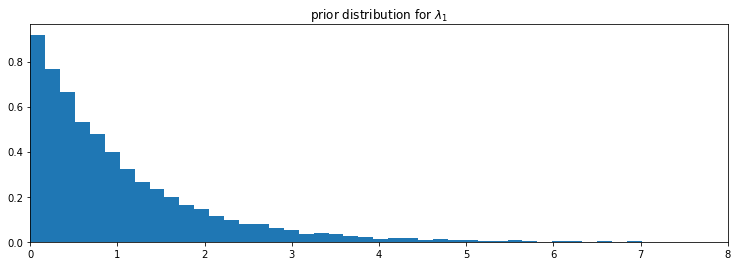

In [53]:
samples = lambda_1.random(size=20000)
plt.figure(figsize=(12.5, 4))
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("prior distribution for $\lambda_1$")
plt.xlim(0, 8);

모델에 측정값을 입력하려면 `observed`에 데이터를 넣어주면 된다.

In [54]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


In [55]:
data = np.array([10, 25, 15, 20, 15])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 15]


In [56]:
obs

obs ~ Poisson

# Example: Bayesian A/B testing

A 웹사이트에 $N$명이 들어와서 $n$명이 구매 $\rightarrow p_A=\frac{n}{N}$  
일단 $p_A$를 균등분포 prior로 가정하자

In [57]:
with pm.Model() as model:
    p = pm.Uniform("p", 0, 1)

In [60]:
# p_true 값을 잘 추정할 수 있는지 확인해보자
p_true = 0.05  # hidden
N = 1500

# sampling
occurences = stats.bernoulli.rvs(p_true, size=N)

print(occurences)
print(np.sum(occurences))

[0 0 0 ... 0 0 0]
78


In [61]:
p_true * N

75.0

In [62]:
# Metropolis 시뮬레이션 시작
with model:
    obs = pm.Bernoulli("obs", p, observed=occurences)
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

/var/folders/m2/xl06qxf96958pj9c450dz5nc0000gn/T/ipykernel_21469/3924705020.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(18000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


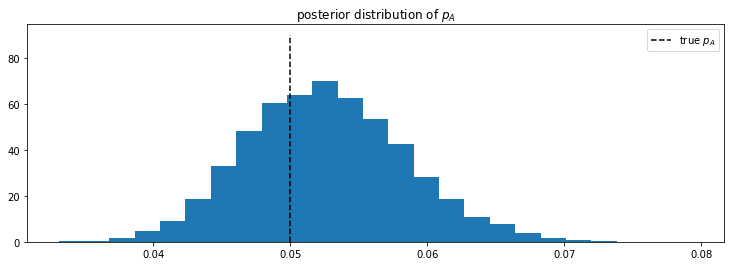

In [66]:
plt.figure(figsize=(12.5, 4))
plt.title("posterior distribution of $p_A$")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$", color="black")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend();

이번에 두가지를 비교해보자.  
A 웹사이트에 $N_A$명이 들어와서 $n_A$명이 구매 $\rightarrow p_A=\frac{n_A}{N_A}$  
B 웹사이트에 $N_B$명이 들어와서 $n_B$명이 구매 $\rightarrow p_B=\frac{n_B}{N_B}$

In [75]:
# p_true 값들과, delta = p_A - p_B 를 추정해보자
p_A_true = 0.05
p_B_true = 0.04

# 샘플 사이즈는 서로 다르다.
N_A = 1500
N_B = 750

observed_A = stats.bernoulli.rvs(p_A_true, size=N_A)
observed_B = stats.bernoulli.rvs(p_B_true, size=N_B)

print(np.mean(observed_A))
print(np.mean(observed_B))

0.05
0.04133333333333333


In [76]:
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    delta = pm.Deterministic("delta", p_A - p_B)
    
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observed_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observed_B)
    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]

/var/folders/m2/xl06qxf96958pj9c450dz5nc0000gn/T/ipykernel_21469/2734986633.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(20000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [71]:
burned_trace.varnames

['p_A_interval__', 'p_B_interval__', 'p_A', 'p_B', 'delta']

In [77]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

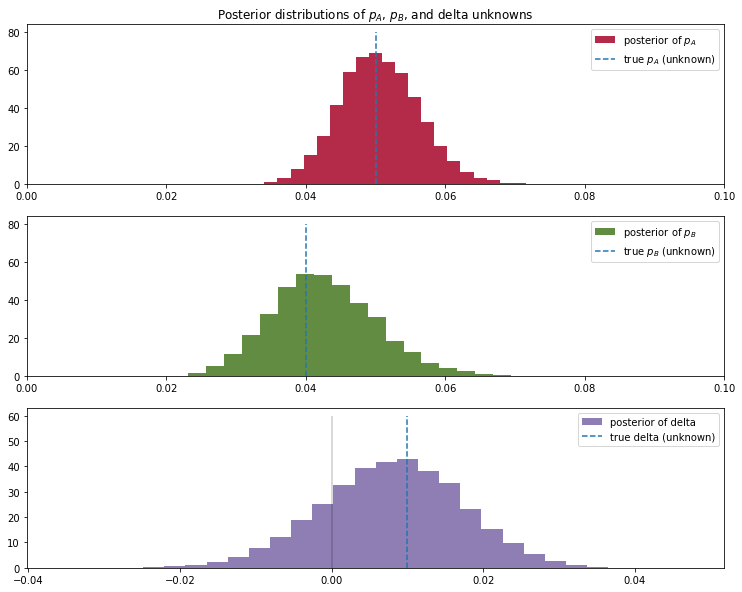

In [78]:
plt.figure(figsize=(12.5, 10))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(p_A_true, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(p_B_true, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(p_A_true - p_B_true, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");